In [13]:
import tensorflow as tf

# Get the list of GPUs
gpus = tf.config.list_physical_devices('GPU')
gpu_name = tf.test.gpu_device_name()

if gpus:
    print(f"✅ SUCCESS: GPU Detected: {gpus[0].name}")
    print(f"   Internal Device Name: {gpu_name}")
else:
    print("❌ ERROR: No GPU found. Please check your setup.")

✅ SUCCESS: GPU Detected: /physical_device:GPU:0
   Internal Device Name: /device:GPU:0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import json
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pyttsx3  # For Text-to-Speech later

# --- CONFIGURATION ---
# With a GPU, we can handle a larger dataset.
NUM_EXAMPLES = 30000

# Paths (Verify these match your folder structure)
ANNOTATION_FILE = r"Dataset/annotations_trainval2017/annotations/captions_train2017.json"
IMAGE_FOLDER = r"Dataset/train2017/train2017/"

print(f"Configuration Complete.")
print(f"Targeting {NUM_EXAMPLES} image-caption pairs for training.")

Configuration Complete.
Targeting 30000 image-caption pairs for training.


In [3]:
# --- STEP 1: LOAD CAPTIONS ---
def load_captions_data(filename):
    with open(filename, 'r') as f:
        annotations = json.load(f)

    all_captions = []
    all_img_name_vector = []

    for annot in annotations['annotations']:
        caption = '<start> ' + annot['caption'] + ' <end>'
        image_id = annot['image_id']
        full_coco_image_path = os.path.join(
            IMAGE_FOLDER, '%012d.jpg' % (image_id))

        all_img_name_vector.append(full_coco_image_path)
        all_captions.append(caption)

    # Shuffle captions and select the subset defined by NUM_EXAMPLES
    all_captions, all_img_name_vector = shuffle(
        all_captions, all_img_name_vector, random_state=1)

    # Slice the list to the limit (30,000)
    train_captions = all_captions[:NUM_EXAMPLES]
    img_name_vector = all_img_name_vector[:NUM_EXAMPLES]

    return train_captions, img_name_vector


# Load Data
print("Loading data...")
train_captions, img_name_vector = load_captions_data(ANNOTATION_FILE)

# --- STEP 2: TOKENIZATION ---
print("Tokenizing vocabulary...")
# Choose the top 5000 words for the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max length of the captions
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

Loading data...
Tokenizing vocabulary...


In [4]:
# --- STEP 3: INCEPTION V3 FEATURE EXTRACTION ---
import tensorflow as tf
import numpy as np
# We use standard 'tqdm' instead of 'tqdm.notebook' to avoid the widget error
from tqdm import tqdm

print("Loading InceptionV3 model...")


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    # Preprocess input as expected by InceptionV3 (-1 to 1 range)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


# Load the pretrained InceptionV3 model
image_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet')

# We want the output from the last convolutional layer
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
print("✅ Inception V3 Model Loaded.")

# --- DEDUPLICATE IMAGES ---
# We only want to process unique images (since 1 image has 5 captions)
# We assume 'img_name_vector' exists from the previous cell
encode_train = sorted(set(img_name_vector))

print(f"Unique images to process: {len(encode_train)}")
print("Starting Feature Extraction... (Watch the text-based progress bar)")

# Create dataset for efficient loading
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# Loop and save .npy files
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, 2048))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

print("✅ Feature Extraction Complete! .npy files saved.")

Loading InceptionV3 model...
✅ Inception V3 Model Loaded.
Unique images to process: 27120
Starting Feature Extraction... (Watch the text-based progress bar)


100%|██████████| 1695/1695 [07:38<00:00,  3.69it/s]

✅ Feature Extraction Complete! .npy files saved.


In [5]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# --- REPAIR: ENSURE VARIABLES EXIST ---
# We re-run the tokenization just to be safe
if 'cap_vector' not in locals():
    print("⚠️ 'cap_vector' was missing. Re-creating it now...")
    top_k = 5000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                      oov_token="<unk>",
                                                      filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    # Create the vector
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
        train_seqs, padding='post')
    print("✅ Text data restored.")

# --- CONFIGURATION PARAMETERS ---
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_vector) // BATCH_SIZE

# --- STEP 1: TRAIN/TEST SPLIT ---
# Splitting 80% for training and 20% for testing (as per paper guidelines)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(
    img_name_vector,
    cap_vector,
    test_size=0.2,
    random_state=0)

print(f"Training Data: {len(img_name_train)} samples")
print(f"Validation Data: {len(img_name_val)} samples")

# --- STEP 2: CREATE TF.DATA DATASET ---


def map_func(img_name, cap):
    # Load the features we saved to disk earlier
    img_tensor = np.load(img_name.decode('utf-8') + '.npy')
    return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and Batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("✅ Data Pipeline Created Successfully.")

⚠️ 'cap_vector' was missing. Re-creating it now...
✅ Text data restored.
Training Data: 24000 samples
Validation Data: 6000 samples
✅ Data Pipeline Created Successfully.


In [6]:
import tensorflow as tf
from tensorflow.keras import layers

# --- COMPONENT 1: ENCODER (Processes Image Features) ---


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Attention Mechanism
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)

        # Normalization and Feed Forward
        self.dense_proj = tf.keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_proj(inputs)

        # Self-Attention on image features
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None, training=training
        )
        # Residual Connection
        proj_input = self.layernorm_2(inputs + attention_output)
        return proj_input


# --- COMPONENT 2: DECODER (Generates Text) ---
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)

        self.dense_proj = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.embedding = PositionalEmbedding(
            50, 5001, embed_dim)  # Defaults, overwritten in model
        self.out = layers.Dense(5001)  # Vocabulary size output

    def call(self, inputs, encoder_outputs, training, mask=None):
        # 1. Self Attention (looking at previous words)
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=None, training=training
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # 2. Cross-Attention (looking at the image)
        attention_output_2 = self.attention_2(
            query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=None, training=training
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        # 3. Feed Forward
        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)


# --- COMPONENT 3: THE FULL MODEL ---
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_feature_dim, embed_dim, dense_dim, num_heads, vocab_size, max_len):
        super().__init__()
        # Encoder
        self.encoder = TransformerEncoderBlock(embed_dim, dense_dim, num_heads)

        # Decoder
        self.pos_embedding = PositionalEmbedding(
            max_len, vocab_size, embed_dim)
        self.decoder = TransformerDecoderBlock(embed_dim, dense_dim, num_heads)

        # Final prediction layer
        self.score = layers.Dense(vocab_size)

    def call(self, inputs, training=False):
        img_features, captions = inputs

        # Pass image features through Encoder
        encoded_img = self.encoder(img_features, training)

        # Pass captions through Positional Embedding
        embedded_captions = self.pos_embedding(captions)

        # Pass both through Decoder
        decoded_output = self.decoder(embedded_captions, encoded_img, training)

        # Predict next words
        preds = self.score(decoded_output)
        return preds


print("✅ Transformer Classes Defined.")

✅ Transformer Classes Defined.


In [7]:
# --- HYPERPARAMETERS ---
EMBED_DIM = 256
DENSE_DIM = 512
NUM_HEADS = 6
VOCAB_SIZE = top_k + 1  # 5001
MAX_LENGTH = 51         # calculated during tokenization

# --- 1. INSTANTIATE THE MODEL ---
caption_model = ImageCaptioningModel(
    cnn_feature_dim=2048,
    embed_dim=EMBED_DIM,
    dense_dim=DENSE_DIM,
    num_heads=NUM_HEADS,
    vocab_size=VOCAB_SIZE,
    max_len=MAX_LENGTH
)

# --- 2. OPTIMIZER & LOSS FUNCTION ---
# Simple Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

# Loss Object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """
    Calculates loss but ignores the padding (0) tokens.
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


# --- 3. CHECKPOINT MANAGER ---
# This saves your progress so you don't lose it if the PC crashes
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(caption_model=caption_model,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

print("✅ Model Initialized & Optimizer Ready.")

✅ Model Initialized & Optimizer Ready.


In [8]:
# --- DEFINING THE TRAINING STEP ---
@tf.function
def train_step(img_tensor, target):
    tar_inp = target[:, :-1]  # Input: "<start> A cat is..."
    tar_real = target[:, 1:]  # Target: "A cat is... <end>"

    with tf.GradientTape() as tape:
        predictions = caption_model((img_tensor, tar_inp), training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, caption_model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, caption_model.trainable_variables))

    return loss


# --- START TRAINING ---
EPOCHS = 20
print(f"🚀 Starting Training for {EPOCHS} Epochs...")

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    # Iterate through every batch in the dataset
    for (batch, (img_tensor, target)) in enumerate(dataset):
        t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        # Print update every 100 batches
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {t_loss.numpy():.4f}')

    # Save checkpoint at end of every epoch
    ckpt_manager.save()

    print(f'✅ Epoch {epoch + 1} Loss {total_loss/num_steps:.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} sec\n')

print("🎉 Training Complete!")

🚀 Starting Training for 20 Epochs...
Epoch 1 Batch 0 Loss 8.5967
Epoch 1 Batch 100 Loss 4.6137
Epoch 1 Batch 200 Loss 4.0572
Epoch 1 Batch 300 Loss 3.6754
✅ Epoch 1 Loss 3.4742
Time taken for 1 epoch: 79.83 sec

Epoch 2 Batch 0 Loss 3.1134
Epoch 2 Batch 100 Loss 2.8786
Epoch 2 Batch 200 Loss 2.1074
Epoch 2 Batch 300 Loss 1.4046
✅ Epoch 2 Loss 1.7651
Time taken for 1 epoch: 53.26 sec

Epoch 3 Batch 0 Loss 1.0899
Epoch 3 Batch 100 Loss 0.8681
Epoch 3 Batch 200 Loss 0.4715
Epoch 3 Batch 300 Loss 0.4467
✅ Epoch 3 Loss 0.4912
Time taken for 1 epoch: 52.39 sec

Epoch 4 Batch 0 Loss 0.3615
Epoch 4 Batch 100 Loss 0.2889
Epoch 4 Batch 200 Loss 0.1831
Epoch 4 Batch 300 Loss 0.1640
✅ Epoch 4 Loss 0.1953
Time taken for 1 epoch: 51.86 sec

Epoch 5 Batch 0 Loss 0.1857
Epoch 5 Batch 100 Loss 0.1995
Epoch 5 Batch 200 Loss 0.0909
Epoch 5 Batch 300 Loss 0.0827
✅ Epoch 5 Loss 0.0949
Time taken for 1 epoch: 51.85 sec

Epoch 6 Batch 0 Loss 0.0707
Epoch 6 Batch 100 Loss 0.0764
Epoch 6 Batch 200 Loss 0.0666


In [9]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("✅ Tokenizer saved as 'tokenizer.pkl'.")
print("✅ Model weights are already saved in './checkpoints/train'.")
print("\nFuture Workflow:")
print("Next time you open this project, you do NOT need to run the training loop.")
print("You will only need to: 1. Define the Model Architecture, 2. Load the Tokenizer, 3. Restore the Checkpoint.")

✅ Tokenizer saved as 'tokenizer.pkl'.
✅ Model weights are already saved in './checkpoints/train'.

Future Workflow:
Next time you open this project, you do NOT need to run the training loop.
You will only need to: 1. Define the Model Architecture, 2. Load the Tokenizer, 3. Restore the Checkpoint.


In [22]:
def evaluate_caption(image_tensor):
    # 1. Extract Features
    temp_input = tf.expand_dims(image_tensor, 0)
    img_tensor_val = feature_extractor(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, 2048))

    # 2. Generate Caption
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    last_word = ""

    for i in range(MAX_LENGTH):
        predictions = caption_model(
            (img_tensor_val, dec_input), training=False)
        predictions = predictions[:, -1, :]

        predicted_id = tf.argmax(predictions, axis=-1)[0].numpy()

        if tokenizer.index_word.get(predicted_id) is None:
            break

        predicted_word = tokenizer.index_word[predicted_id]

        # Stop loops
        if predicted_word == last_word:
            break

        if predicted_word == '<end>':
            return result

        result.append(predicted_word)
        last_word = predicted_word
        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Testing on image: Dataset/train2017/train2017/000000314613.jpg


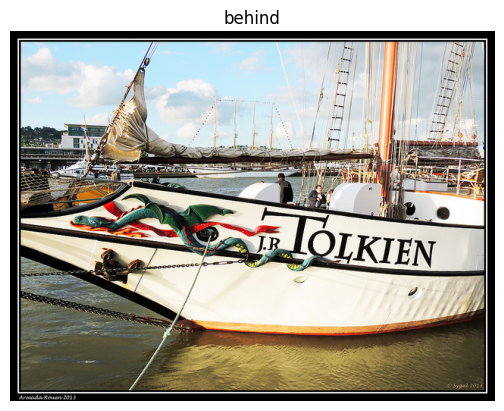

Predicted Caption: behind


In [23]:
import pyttsx3
import matplotlib.pyplot as plt


def generate_caption(image_path):
    # 1. Generate the caption text
    # The evaluate function returns a list of words
    result = evaluate(image_path)

    # 2. Clean up the caption (remove <start>, <end>, and join words)
    predicted_caption = ' '.join(result).replace(
        '<start>', '').replace('<end>', '')

    # 3. Display the Image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(predicted_caption)
    plt.axis('off')
    plt.show()

    print(f"Predicted Caption: {predicted_caption}")

    # 4. Speak the Caption (Text-to-Speech)
    try:
        engine = pyttsx3.init()
        # Set properties (optional)
        engine.setProperty('rate', 150)    # Speed percent (can go over 100)
        engine.setProperty('volume', 0.9)  # Volume 0-1

        engine.say(predicted_caption)
        engine.runAndWait()
    except Exception as e:
        print(f"Audio Error (Common in notebooks): {e}")


# --- TEST ON A RANDOM IMAGE ---
# Pick a random image from the validation set
rid = np.random.randint(0, len(img_name_val))
image_path = img_name_val[rid]

print(f"Testing on image: {image_path}")
generate_caption(image_path)